In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from datetime import datetime, timezone
from pyspark.ml.classification import RandomForestClassifier, BinaryLogisticRegressionSummary
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.pipeline import PipelineModel
import seaborn as sns
from pyspark.sql import functions as F

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("US_Accidents") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR") #supress warnings

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/05 19:54:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in Data
df = spark.read.parquet("data/final_dataset_binary.parquet")

In [4]:
# Binary Classification (1 or 2 vs 3 or 4)
#df = df.drop('Severity')
df.show(5)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+-----------------+---------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Percent_Age_15-24|Severity_Binary|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+-----------------+---------------+
|         21|      85|      30|         1|        10|            0|      1|        1|   0|   1|(3

In [5]:
# Create list of features
feature_list = []
for col in df.columns:
    if col == 'Severity':
        continue
    elif col == 'Severity_Binary':
        continue
    else:
        feature_list.append(col)

In [6]:
# Split the data into train and test
splits = df.randomSplit([0.8, 0.2], 314)
train = splits[0]
test = splits[1]

In [7]:
# Undersampling
# Group by 'Severity' and count occurrences
class_counts = train.groupBy("Severity_Binary").count()

# Use PySpark's min() function to find the minimum count
min_class_size = class_counts.agg(F.min('count')).collect()[0][0]

undersampled_train_list = []

for row in class_counts.collect():
    class_label = row['Severity_Binary']
    class_size = row['count']

    if class_size > min_class_size:
        class_data = train.filter(F.col("Severity_Binary") == class_label) #sample the data for this class to the size of the minimum class
        class_data_undersampled = class_data.sample(withReplacement=False, fraction=min_class_size / class_size)
    else:
        
        class_data_undersampled = train.filter(F.col("Severity_Binary") == class_label) #for classes that are already at the minimum size, keep all samples

    undersampled_train_list.append(class_data_undersampled)

# Combine all the undersampled DataFrames
undersampled_train = undersampled_train_list[0]  # start with the first one
for df in undersampled_train_list[1:]:
    undersampled_train = undersampled_train.union(df)

undersampled_train.show()

# Group by 'Severity' and count the occurrences in the undersampled DataFrame
undersampled_class_counts = undersampled_train.groupBy("Severity_Binary").count()

# Show the result
undersampled_class_counts.show()

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+-----------------+---------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Percent_Age_15-24|Severity_Binary|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+-----------------+---------------+
|        -23|      78|      29|         9|         6|            0|      1|        1|   0|   0|(3

+---------------+-------+
|Severity_Binary|  count|
+---------------+-------+
|              1|1041474|
|              0|1041662|
+---------------+-------+



In [8]:
# Assemble data for logistic regression model
assembler = VectorAssembler(inputCols=feature_list,
                            outputCol="features")

undersampled_train = assembler.transform(undersampled_train)
test = assembler.transform(test)

In [9]:
# Standardize the predictors
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(undersampled_train)
scaledTrainData = scalerModel.transform(undersampled_train)
scaledTestData = scalerModel.transform(test)

In [10]:
# Fit logistic regression model with intercept
from pyspark.ml.classification import LogisticRegression

# instantiate the model
lr = LogisticRegression(labelCol='Severity_Binary',
                        featuresCol='scaledFeatures', 
                        maxIter=50, 
                        regParam=0.0, 
                        elasticNetParam=0.0)

# Fit the model
lrModel = lr.fit(scaledTrainData)

print(f"Detected number of classes: {lrModel.numClasses}")
print("Coefficients: " + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Detected number of classes: 2
Coefficients: DenseMatrix([[-0.16178933,  0.01074926,  0.15373644,  0.04547736,  0.14624979,
               0.00893522, -0.05405357, -0.00071016,  0.05342508, -0.01462183,
              -0.32910362, -0.18553596, -0.11128595, -0.0477622 ,  0.55539784,
               0.0315031 , -0.10321221, -0.00929552,  0.04695992,  0.01416244,
              -0.1933862 , -0.132195  , -0.03262011]])
Intercept: [-3.971277942232109]


In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Compute predictions. this will append column "prediction" to dataframe
lrPred = lrModel.transform(scaledTestData)
lrPred.select("prediction").distinct().show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="Severity_Binary",
    predictionCol="prediction",
    metricName='truePositiveRateByLabel', 
    metricLabel=1.0
)

recall = evaluator.evaluate(lrPred)
print(f"Recall for label 1.0: {recall}")

accuracy = evaluator.evaluate(lrPred, {evaluator.metricName: "accuracy"})
print(f'Accuracy: {accuracy}')

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



Recall for label 1.0: 0.5730434316436016


Accuracy: 0.6869955475895816


In [12]:
precision = evaluator.evaluate(lrPred, {evaluator.metricName: 'weightedPrecision'})
f1_score = evaluator.evaluate(lrPred, {evaluator.metricName: 'f1'})

print(f'Precision: {precision}')
print(f'F1 Score: {f1_score}')

Precision: 0.7745239626181084
F1 Score: 0.716552987338213


In [13]:
# Add a column to indicate correct or incorrect predictions
predictions = lrPred.withColumn(
    'is_correct', F.expr("CASE WHEN Severity_Binary = prediction THEN 1 ELSE 0 END")
)

# Calculate accuracy by class
accuracy_by_class = predictions.groupBy('Severity_Binary').agg(
    (F.sum('is_correct') / F.count('Severity_Binary')).alias('accuracy')
)

accuracy_by_class.show()

+---------------+------------------+
|Severity_Binary|          accuracy|
+---------------+------------------+
|              1|0.5730434316436016|
|              0|0.7129889573510221|
+---------------+------------------+



In [14]:
# Calculate metrics by class
labels = [row['Severity_Binary'] for row in lrPred.select('Severity_Binary').distinct().orderBy('Severity_Binary').collect()]

metrics = {}
for label in labels:
    # Filter predictions for the current label
    true_positive = lrPred.filter((F.col('Severity_Binary') == label) & (F.col('prediction') == label)).count()
    false_positive = lrPred.filter((F.col('Severity_Binary') != label) & (F.col('prediction') == label)).count()
    false_negative = lrPred.filter((F.col('Severity_Binary') == label) & (F.col('prediction') != label)).count()
    true_negative = lrPred.filter((F.col('Severity_Binary') != label) & (F.col('prediction') != label)).count()

    # Precision, Recall, and F1 Score
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    # Store metrics
    metrics[label] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}

for label, metric in metrics.items():
    print(f"Class {label} - Precision: {metric['precision']:.4f}, Recall: {metric['recall']:.4f}, F1 Score: {metric['f1_score']:.4f}")

Class 0 - Precision: 0.8798, Recall: 0.7130, F1 Score: 0.7877
Class 1 - Precision: 0.3129, Recall: 0.5730, F1 Score: 0.4048


In [15]:
# Calculate unique labels
labels = [row['Severity_Binary'] for row in lrPred.select('Severity_Binary').distinct().orderBy('Severity_Binary').collect()]

metrics = {}
confusion_matrix = {label: {l: 0 for l in labels} for label in labels}

# Update the confusion matrix
confusion_matrix_df = (
    lrPred
    .groupBy("Severity_Binary", "prediction")
    .count()
    .rdd
    .map(lambda row: Row(
        actual=row["Severity_Binary"], 
        predicted=row["prediction"], 
        count=row["count"]
    ))
    .toDF()
)

for row in confusion_matrix_df.collect():
    confusion_matrix[row['actual']][row['predicted']] = row['count']

for label, metric in metrics.items():
    print(f"Class {label} - Precision: {metric['precision']:.4f}, Recall: {metric['recall']:.4f}, F1 Score: {metric['f1_score']:.4f}")

print("\nConfusion Matrix:")
print("Actual \\ Predicted")
header = "\t" + "\t".join([str(l) for l in labels])
print(header)

for actual, predictions in confusion_matrix.items():
    row = [str(predictions[p]) for p in labels]
    print(f"{actual}\t" + "\t".join(row))


Confusion Matrix:
Actual \ Predicted
	0	1
0	816254	328580
1	111498	149648


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


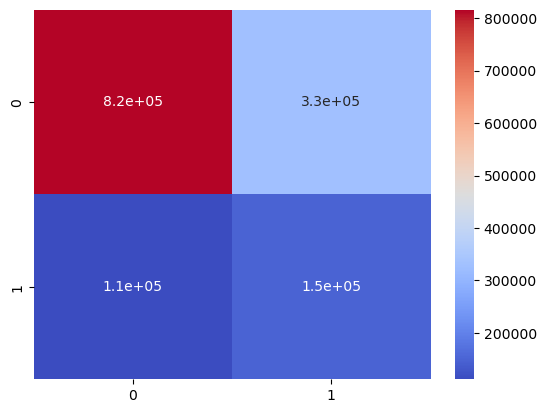

In [16]:
#Evaluate (Confusion Matrix, Accuracy, Weighted Precision, Recall, and F1 Score)
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = lrPred.select("prediction", "Severity_Binary")
rdd = predictionAndLabels.rdd.map(lambda x: tuple(map(float, x)))
multi_metrics = MulticlassMetrics(rdd)

# Plot confusion matrix
cf = multi_metrics.confusionMatrix().toArray()
cf_df = pd.DataFrame(cf, columns=['0', '1'])
sns.heatmap(cf_df, annot=True, cmap="coolwarm")
plt.show()